# Neural Network Type Classification | TMNIST

## Abstract

Handwritten Digit Classification is a fundamental example in the field of Computer Vision. It is the process of developing the capabilities for machines to understand handwritten characters and digits, which has various applications ranging from Biometrics to creation of Digital Libraries. In this notebook we build specific type of neural network called [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN)  - which is commonly used for image classification projects - to classification digits and characters. For this tutorial, we will an extended version of the classifical MNIST dataset - [TMIST](https://www.kaggle.com/datasets/nimishmagre/tmnist-glyphs-1812-characters/data). The CNN model achieved an test accuracy of ~91%.

# Dataset
## TMNIST (Typography MNIST) Glyphs:

This dataset is taken from Kaggle. It has over 500,000 MNIST style images made from 1,819 unique glyphs and 2,990 font-styles

The structure of the csv file is:

* The first row contains column headers ['font_name','glyph_name', 'label','1','2',…..'784']
* The 'font_name' column contains font file names such as 'Acme-Regular' and 'ZillaSlab-Bold'
* The 'glyph_name' column contains the unicodedata name for the glyph such as 'LATIN CAPITAL LETTER A' and 'DEVANAGARI LETTER AA'
* For glyphs that are represented by more than 1 unicode character, the 'glyph_name' column contains the the individual names of both the characters concatenated with a '+' sign. For ex: 'अं' has the 'glyph_name' = 'DEVANAGARI LETTER A + DEVANAGARI SIGN ANUSVARA'
* The 'label' column contains characters such as 'ش','E' or 'छ'
* The remaining 784 columns contain the grayscale pixel values for the image of the corresponding character in the 'font_name' font-style

### Install the necessary libraries

In [1]:
! pip install -q kaggle
! pip install tensorflow

### Import Libraries

We will be using the [Tensorflow](https://www.tensorflow.org/tutorials/images/cnn) library to build our CNN model.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, precision_recall_fscore_support


### Load the data and identify images and labels

In [3]:
# Function to load the CSV file containing the dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    labels = data.iloc[:, 2]  # Third column contains the labels in this dataset
    images = data.iloc[:, 3:]  # pixel values
    return images, labels


In [4]:
# Load the dataset and preprocess the data
file_path = 'Glyphs_TMNIST_updated.csv'

images, labels = load_data(file_path)


## Explore Data

In [5]:
df_tmnist = pd.read_csv(file_path)
df_tmnist.head(10)

,font_name,glyph_name,label,1,2,3,4,5,6,7,...,775,776,777,778,779,780,781,782,783,784
0,ABeeZee-Regular,LATIN CAPITAL LETTER A,A,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABeeZee-Regular,LATIN CAPITAL LETTER B,B,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ABeeZee-Regular,LATIN CAPITAL LETTER C,C,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ABeeZee-Regular,LATIN CAPITAL LETTER D,D,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ABeeZee-Regular,LATIN CAPITAL LETTER E,E,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,ABeeZee-Regular,LATIN CAPITAL LETTER F,F,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,ABeeZee-Regular,LATIN CAPITAL LETTER G,G,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,ABeeZee-Regular,LATIN CAPITAL LETTER H,H,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ABeeZee-Regular,LATIN CAPITAL LETTER I,I,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ABeeZee-Regular,LATIN CAPITAL LETTER J,J,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_tmnist.shape

(565292, 787)

In [7]:
df_tmnist.isna().sum()

font_name     0
glyph_name    0
label         0
1             0
2             0
             ..
780           0
781           0
782           0
783           0
784           0
Length: 787, dtype: int64

In [8]:
# No of classes

df_tmnist['label'].unique()

array(['A', 'B', 'C', ..., '_', '~', '|'], dtype=object)

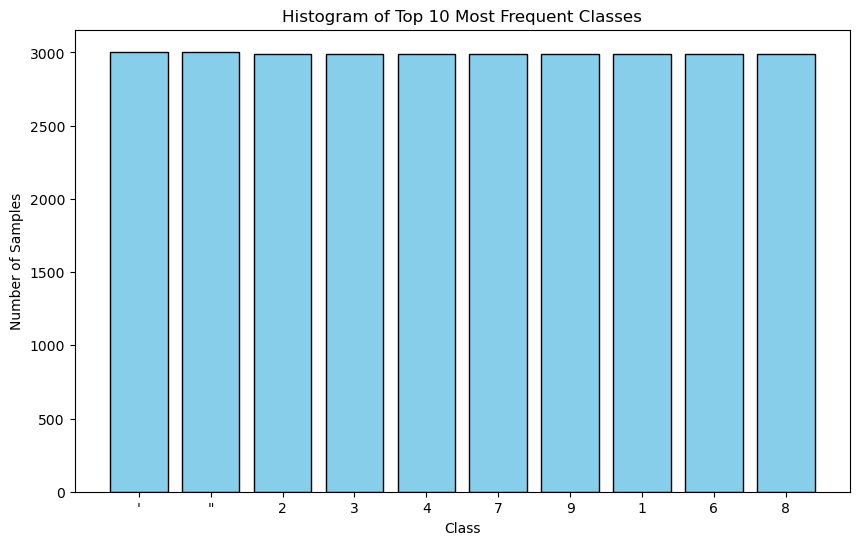

In [9]:
# Plot histogram for top 10 most frequent classes

# count the occurrences of each class
class_counts = Counter(df_tmnist['label'])

# Get the top 10 most frequent classes
top_classes = class_counts.most_common(10)

# Extract class labels and counts for plotting
top_class_labels, top_class_counts = zip(*top_classes)

# Plot a histogram of the top 10 most frequent classes
plt.figure(figsize=(10, 6))
plt.bar(top_class_labels, top_class_counts, color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Histogram of Top 10 Most Frequent Classes')
plt.show()

### Preprocess the data and split the data into train and test sets

We reshape the image array to 28x28(height and width) pixels array to pass it as input to the CNN model, with 1 channel as these are gray scale images. We perform a 80 - 20 (train - test) split

In [13]:
# Function to preprocess the data and return training and testing sets
def preprocess_data(images, labels):
    # Normalize pixel values to be between 0 and 1
    images = images / 255.0
    # Reshape the data to the format (number of samples, height, width, channels)
    images = images.values.reshape(-1, 28, 28, 1)

    # Convert labels to one-hot encoding
    lb = LabelBinarizer()
    class_labels = lb.fit_transform(labels)

    # Split the data into training and testing sets
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, class_labels, test_size=0.2, random_state=42
    )
    return train_images, test_images, train_labels, test_labels

In [14]:
train_images, test_images, train_labels, test_labels = preprocess_data(images, labels)


#### Visualize a sample of images 

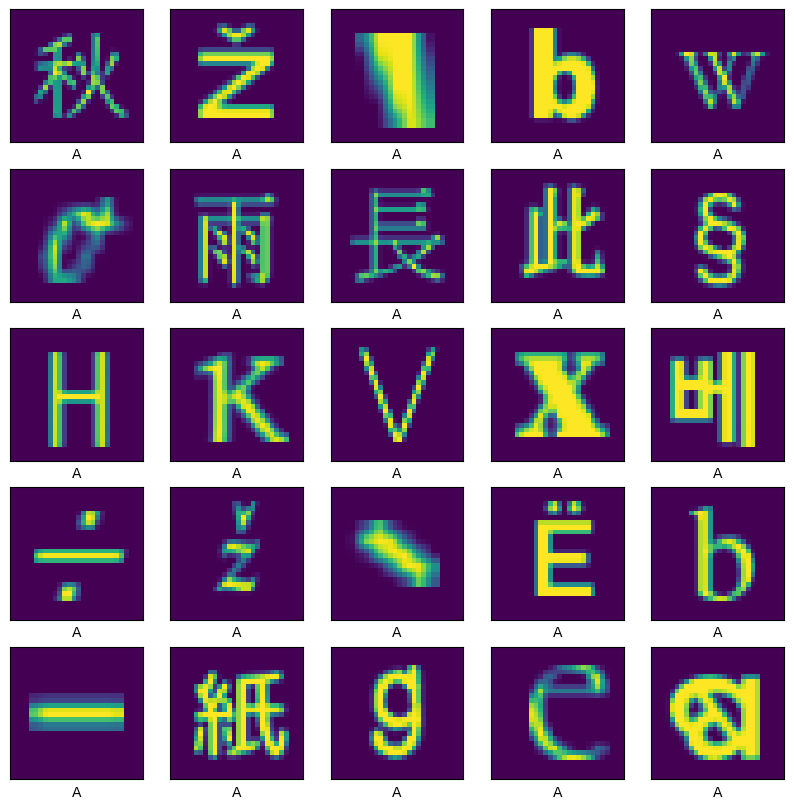

In [15]:
# Display the 25 images 

class_names = labels[:25]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Build Convolutional Neural Network

A Convolutional Neural Network is a commonly used model for image classification tasks, due to the inherent capabilities of capturing hierarchical feature representations from image data. Let us examine the different layers in the CNN model



<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*vkQ0hXDaQv57sALXAJquxA.jpeg" alt="" width="800" height="400"/>

**Conv2D Layer**: Convolutional layers are used to extract features from input images by performing a convolution operation, where a sliding window(kernel) of various sizes with different filter values is used to capture different features such as edges, corners etc. It uses the ReLU activation function which helps in learning complex patterns and representations. In this model we use convolution layer with 64 filters(kernel) of size (3,3). The input is 28x28 2d array.

**BatchNormalization Layer**: Batch normalization normalizes(subtracting the mean and dividing by the standard deviation) the activations of the previous layer, helping to stabilize and accelerate the training process.

**MaxPooling2D Layer**: Max pooling reduces spatial dimensions, retaining the most important information while reducing computational complexity.

**Dropout**: Dropout is a regularization technique that randomly sets a fraction of input units to zero during training, helping prevent overfitting of the model to train data.

**Flatten Layer**: Transforms the output of the previous layer into 1D array, preparing it for fully connected layers.

**Dense Layer**: Dense Layer is a fully connected layer, usually containing nodes equivalent to number of classes(1819) and uses softmax activation function for multiclass classification. Softmax function converts the model's raw output into probability distributions over multiple classes.

#### Hyperparameters :

* Number of Filters (64 and 128)
* Filter Size ((3, 3))
* Activation Function (ReLU)
* Pooling Window Size ((2, 2))
* Dropout Rates (0.10 and 0.25)
* Number of Neurons in Dense Layer (128)
* Number of Epochs (10)
* Learning Rate(0.01)

Model performance can be improved by optimizing the above hyperparameters

In [16]:
# Function to build the convolutional neural network (CNN) model
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28,28, 1)))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.10))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1819, activation='softmax'))
    return model



In [17]:
# Build the model
model = build_model()

# Model Summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                        

In [18]:
# Create a ModelCheckpoint to save the best model and best weights
checkpoint_path = "cnn_glyph_cp.ckpt"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)


# Train the model
train_metrics = model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2, verbose=1, callbacks=[checkpoint_callback])



Epoch 1/10
5653/5653 [==============================] - ETA: 0s - loss: 0.9229 - accuracy: 0.7826
Epoch 1: val_loss improved from inf to 0.47361, saving model to cnn_glyph_cp.ckpt
5653/5653 [==============================] - 371s 66ms/step - loss: 0.9229 - accuracy: 0.7826 - val_loss: 0.4736 - val_accuracy: 0.8600
Epoch 2/10
5653/5653 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.8720
Epoch 2: val_loss improved from 0.47361 to 0.38711, saving model to cnn_glyph_cp.ckpt
5653/5653 [==============================] - 377s 67ms/step - loss: 0.4171 - accuracy: 0.8720 - val_loss: 0.3871 - val_accuracy: 0.8838
Epoch 3/10
5653/5653 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.8903
Epoch 3: val_loss improved from 0.38711 to 0.35935, saving model to cnn_glyph_cp.ckpt
5653/5653 [==============================] - 382s 68ms/step - loss: 0.3434 - accuracy: 0.8903 - val_loss: 0.3594 - val_accuracy: 0.8894
Epoch 4/10
5653/5653 [======================

#### Verify - Model Overfitting

We check the train accuracy and validation accuracy to determine if the model overfits the train data i.e, performance improves on train data while degrades on validation data

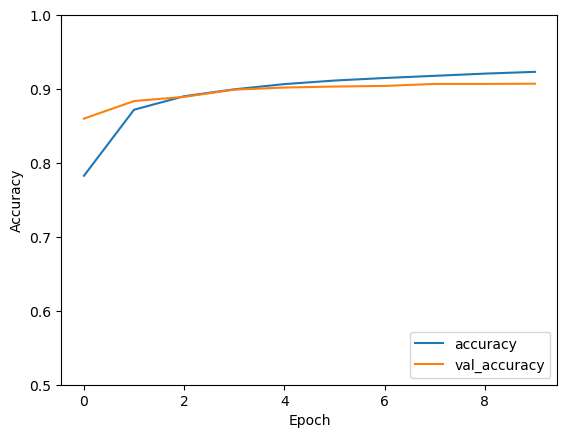

In [19]:
# Plot to check for model overfitting

plt.plot(train_metrics.history['accuracy'], label='accuracy')
plt.plot(train_metrics.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

As evident from the plot above, we see that the model doesn't overfit and achieves an accuracy of 92.2% and validation accuracy of 90%

In [20]:
# Save the model to a file for later use
model.save('cnn_glyph.h5')

/Users/akshaybharadwaj/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Evaluation

Evaluate the model on test data to determine the its performance to understand how well the model can generalize on unseen images.

In [21]:
# Load the model from the file
loaded_model = tf.keras.models.load_model('cnn_glyph.h5')

##### Model Accuracy

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = loaded_model.evaluate(test_images, test_labels)
print(f'\n Test accuracy: {test_acc}')

3534/3534 [==============================] - 36s 10ms/step - loss: 0.3165 - accuracy: 0.9055

 Test accuracy: 0.9055095314979553


##### Overall Classification Metrics

In [23]:
# Generate predictions for the test set
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)



3534/3534 [==============================] - 35s 10ms/step


In [24]:
# Calculate and display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       600
           1       0.88      0.87      0.87       593
           2       0.99      0.99      0.99       586
           3       0.99      0.99      0.99       575
           4       0.99      0.99      0.99       603
           5       0.99      0.96      0.98       594
           6       0.84      0.89      0.87       621
           7       0.97      0.99      0.98       566
           8       0.96      0.99      0.97       569
           9       0.99      0.99      0.99       565
          10       0.98      0.98      0.98       590
          11       0.49      0.87      0.63       549
          12       0.85      0.89      0.87       598
          13       0.96      0.98      0.97       601
          14       0.89      0.96      0.93       609
          15       0.73      0.66      0.69       640
          16       0.93      0.91      0.92       596
    

/Users/akshaybharadwaj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akshaybharadwaj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akshaybharadwaj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users

##### Misclassified Samples

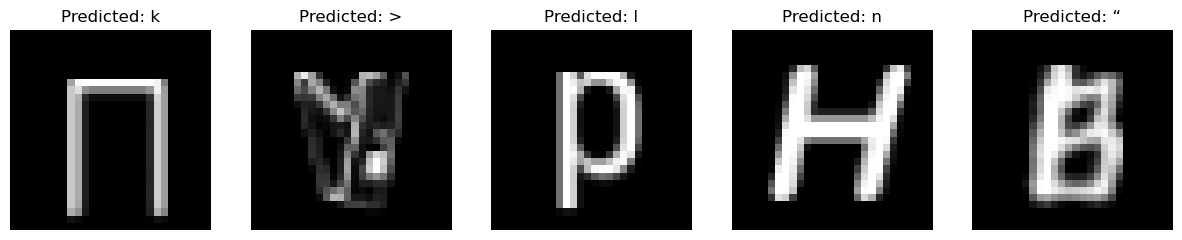

In [35]:
# Find indices of misclassified samples
misclassified_indices = np.where(y_pred != np.argmax(test_labels, axis=1))[0]

# Randomly select a subset of misclassified samples for display
num_samples_to_display = 5
selected_indices = np.random.choice(misclassified_indices, num_samples_to_display, replace=False)

# Display the misclassified images along with their true and predicted labels
plt.figure(figsize=(15, 3))
for i, index in enumerate(selected_indices):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(test_images[index].reshape(28, 28), cmap='gray')
    pred_lb = df_tmnist['label'][y_pred[index]]
    plt.title(f'Predicted: {pred_lb}')
    plt.axis('off')

plt.show()

### CONCLUSION
* The model achieved an accuracy of 90.55% on the test set
* We can further improve the model performance by:
    * Hyperparameter Tuning
    * Data Augmentation
    * Improving the model architecture
    

## References

* Sklearn Metrics - https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
* Dataset - https://www.kaggle.com/datasets/nimishmagre/tmnist-glyphs-1812-characters/data
* Tensorflow CNN - https://www.tensorflow.org/tutorials/images/cnn
* Distributions - https://matplotlib.org/stable/gallery/statistics/hist.html



## License

The algorithms were referred directly from the Tensorflow, Sckit Learn official documentation. Visualization was referred from the matplotlib and Seaborn official documentation. 

Copyright 2023 Akshay Bharadwaj

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.